<a href="https://colab.research.google.com/github/Cuong2812/Stock-Price-Predictions/blob/main/VIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Predictions of MSN stock



## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanAbsolutePercentageError, MeanSquaredError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

### Auxilary functions

In [2]:
def write_values(rects, ax):
  heights = [r.get_height() for r in rects]
  rel_heights = [h/max(heights) for h in heights]
  idx = heights.index(max(heights))
  for i,(r,h, rh) in enumerate(zip(rects, heights, rel_heights)):
      ax.text(r.get_x() + r.get_width()/2.0, h + max(heights) * .01, f'{h:.2}', ha='center')

def factor_int(n):
  val = math.ceil(math.sqrt(n))
  val2 = int(n/val)
  while val2 * val != float(n):
    val -= 1
    val2 = int(n/val)
  return val, val2

## Import Dataset

In [3]:
VIC = pd.read_csv('/content/VIC.csv', usecols = ['Name','Date','Open','Close','High','Low','Volume'])

In [4]:
VIC['Date'] = pd.to_datetime(VIC['Date'])

## Create Dataset

In [5]:
#Stock name encoder
name_encoder = OrdinalEncoder()
#Value scaler
scaler = MinMaxScaler(feature_range=(0,1))

feature_cols = [
                # 'Movement',
                'Close', 
                # 'Open', 'Daily_High', 'Daily_Low', "Volume", 
                # 'avg',
                # "ma7", "ma21", "ema26", "ema12", "MACD", "upper_band", "lower_band", "ema", "momentum",
                "Year", "Month", "Day", "Name"]

def create_timeseries(data, lag):
  x = []
  y = []

  for i in range(lag, len(data)):
      x.append(data[i - lag:i, :])
      y.append(data[i, 0])
  
  x, y = np.array(x), np.array(y)
  x = np.reshape(x, (x.shape[0], x.shape[1], -1))

  assert len(x) == len(y)
  return x, y

def create_lag_features(data, lag):
  x = []
  y = []

  for i in range(lag, len(data)):
      x.append(data[i - lag:i, :])
      y.append(data[i, 0])
  
  x, y = np.array(x), np.array(y)
  x = np.reshape(x, (x.shape[0], -1))

  assert len(x) == len(y)
  return x, y

def create_dataset(df, lag=60, dataset_format='timeseries', stock=None, target="regression"):
  if stock:
    #Keep only one specific stock
    X = df[df['Name'] == stock].copy()
  else:
    #Keep all stocks
    X = df.copy()
  
  #Convert name from string to int
  X['Name'] = name_encoder.fit_transform(X['Name'].to_numpy().reshape(-1,1))

  #Convert volume from string to float
  X['Volume'] = X['Volume'].astype('float')

  #Create additional features and technical indicators
  #Average of given prices
  X['avg'] = X[['Close', 'Open', 'High', 'Low']].mean().mean()
  # Create 7 and 21 days Moving Average
  X['ma7'] = X['Close'].rolling(window = 7).mean()
  X['ma21'] = X['Close'].rolling(window = 21).mean()
  #Create MACD
  X['ema26'] = X['Close'].ewm(span=26).mean()
  X['ema12'] = X['Close'].ewm(span=12).mean()
  X['MACD'] = (X['ema12']-X['ema26'])
  #Create Bollinger Bands
  X['20sd'] = X['Close'].rolling(window = 20).std()
  X['upper_band'] = (X['Close'].rolling(window = 20).mean()) + (X['20sd']*2)
  X['lower_band'] = (X['Close'].rolling(window = 20).mean()) - (X['20sd']*2)
  #Create Exponential moving average
  X['ema'] = X['Close'].ewm(com=0.5).mean()
  #Create Momentum
  X['momentum'] = X['Close'].rolling(window=10).apply(lambda x: x.iat[-1] - x.iat[0])


  #Break day into year, month, day and time(hours, minutes, seconds)
  X['Date'] = pd.to_datetime(X['Date'])
  X['Year'] = X['Date'].dt.year
  X['Month'] = X['Date'].dt.month
  X['Day'] = X['Date'].dt.day
  X['Time'] = X['Date'].dt.time

  #Throw away original date column
  X = X.drop(columns=['Date'])
  year = X['Year']

  #Move target column to first column
  if target == 'regression':
    close = X.pop("Close")
    X.insert(0, "Close", close)
  elif target == 'classification':
    X['Movement'] = X['Close'].rolling(window=2).apply(lambda x: 1 if x.iat[-1] > x.iat[0] else 0)
    X['Movement'].iat[0] = 0
    movement = X.pop("Movement")
    X.insert(0, "Movement", movement)
  else:
    raise ValueError()

  #Keep only necessary features
  X = pd.DataFrame(X, columns=feature_cols)

  # Normalize data
  if scaler != None:
    X = scaler.fit_transform(X)
  else:
    X = X.to_numpy()

  #Split into train, test
  train_points = year
  train_data = X[0:81013, :]
  
  test_points = year
  test_data = X[-20253:, :]

  if dataset_format == 'timeseries':
    X_train, y_train = create_timeseries(train_data, lag)
    X_test, y_test = create_timeseries(test_data, lag)
  elif dataset_format == 'lag_features':
    X_train, y_train = create_lag_features(train_data, lag)
    X_test, y_test = create_lag_features(test_data, lag)

  return (X_train, y_train), (X_test, y_test)


def next_day(row):
  year, month, day = round(row['Year'].item()), round(row['Month'].item()), round(row['Day'].item())
  new_date = pd.Timestamp(year=year, month=month, day=day)
  return new_date

def dataset_to_df(X, Y, lag=60):
  if X.ndim == 3:
    last_days = X[:, -1, :]
  elif X.ndim == 2:
    n_feat = int(X.shape[1]/lag)
    last_days = X[:, -n_feat:]
  new_df = pd.DataFrame(last_days, columns=feature_cols)
  #Replace closing price with y and scale back to original values
  new_df['Close'] = Y
  if scaler != None:
    new_df = pd.DataFrame(scaler.inverse_transform(new_df), columns=feature_cols)
  #Go to next day (i.e. day of the prediction)
  new_df['Date'] = new_df.apply(next_day, axis=1)
  #Convert name to string
  new_df["Name"] = name_encoder.inverse_transform(new_df["Name"].to_numpy().reshape(-1, 1))

  return pd.DataFrame(new_df, columns=['Name', "Date", "Close"])

In [6]:
(X_train, y_train), (X_test, y_test) = create_dataset(VIC, stock="VIC")

print(f"X_train: {str(X_train.shape):14}, y_train: {y_train.shape}")
print(f"X_test:  {str(X_test.shape):14}, y_test:   {y_test.shape}")

X_train: (80953, 60, 5), y_train: (80953,)
X_test:  (20193, 60, 5), y_test:   (20193,)


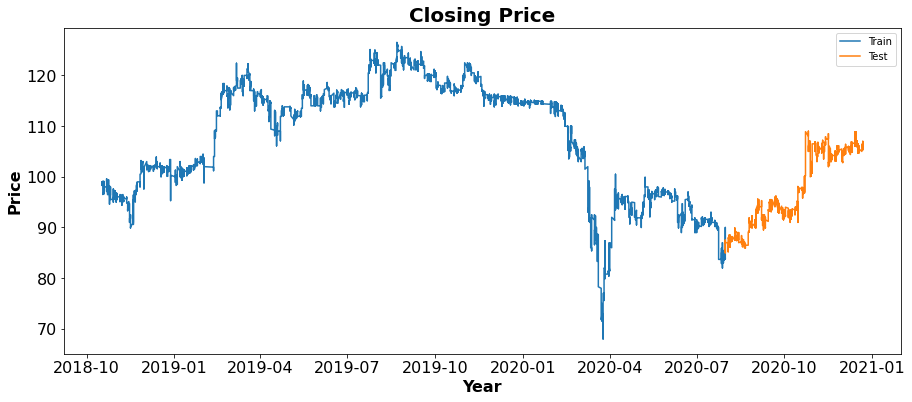

In [7]:
train_df = dataset_to_df(X_train, y_train)
test_df = dataset_to_df(X_test, y_test)

# Line plot
fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(train_df['Date'], train_df['Close'], label="Train")
plt.plot(test_df['Date'], test_df['Close'], label="Test")

# Formatting
ax.set_title('Closing Price', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Price', fontsize = 16, fontdict=dict(weight='bold'))
ax.legend()
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

## Predicting prices with regression

In [8]:
results = {}
target = "regression"

#The following variables can be changed to alter the experiment

#Value scaler can be set to None for no scaling
scaler = MinMaxScaler(feature_range=(0,1))
# scaler = None

feature_cols = [
                'Close', 
                'Open', 'High', 'Low', "Volume", 
                'avg',
                # "ma7", "ma21", "ema26", "ema12", "MACD", "upper_band", "lower_band", "ema", "momentum",
                "Year", "Month", "Day", "Name"]
lag = 30
stock_name = "VIC"

### Neural models

#### Define models

In [9]:
def LSTM_model(inp_shape):
  model = Sequential()
  model.add(LSTM(32, input_shape=(inp_shape), return_sequences = True))
  model.add(LSTM(16))
  model.add(Dense(1))
  model.add(Activation('relu'))
  return model


#### Train models

In [10]:
model_create_funcs = {"LSTM" : (LSTM_model, "timeseries")}

for name, (create_func, dataset_format) in model_create_funcs.items():
  #Create dataset
  (X_train, y_train), (X_test, y_test) = create_dataset(VIC, lag=lag, dataset_format=dataset_format, stock=stock_name, target=target)
  #Create model
  if X_train.ndim == 3:
    model = create_func((X_train.shape[1], X_train.shape[2]))
  elif X_train.ndim == 2:
    model = create_func((X_train.shape[1],))
  # model.summary()
  model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])

  #Define callbacks
  early_stopper = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
  cbs = [early_stopper]

  #Train model
  model.fit(X_train, y_train, validation_split=0.1, epochs=40, batch_size=150, verbose=1, callbacks=cbs)

  #Make predictions on test set
  predicted_prices = model.predict(X_test)
  #Convert predictions
  pred_df = dataset_to_df(X_test, predicted_prices, lag=lag)
  #Get metrics on test set
  mse = MeanSquaredError()(predicted_prices, y_test)
  mape = MeanAbsolutePercentageError()(predicted_prices, y_test) 
  #Make predictions on train set
  predicted_prices = model.predict(X_train)
  #Get metrics on train set
  train_mse = MeanSquaredError()(predicted_prices, y_train)
  train_mape = MeanAbsolutePercentageError()(predicted_prices, y_train)

  results[name] = {
      "pred" : pred_df,
      "mse" : mse,
      "mape" : mape,
      "train_mse" : mse,
      "train_mape" : mape
  }

Epoch 1/40
486/486 [==============================] - 28s 48ms/step - loss: 0.0020 - mean_absolute_percentage_error: 451.7995 - val_loss: 1.1895e-04 - val_mean_absolute_percentage_error: 2.4257
Epoch 2/40
486/486 [==============================] - 23s 48ms/step - loss: 4.6040e-05 - mean_absolute_percentage_error: 1075.0522 - val_loss: 3.2218e-05 - val_mean_absolute_percentage_error: 0.9582
Epoch 3/40
486/486 [==============================] - 22s 44ms/step - loss: 3.3197e-05 - mean_absolute_percentage_error: 994.7013 - val_loss: 2.9544e-05 - val_mean_absolute_percentage_error: 0.9077
Epoch 4/40
486/486 [==============================] - 25s 52ms/step - loss: 3.2554e-05 - mean_absolute_percentage_error: 976.5384 - val_loss: 3.0909e-05 - val_mean_absolute_percentage_error: 0.9193
Epoch 5/40
486/486 [==============================] - 24s 49ms/step - loss: 3.1116e-05 - mean_absolute_percentage_error: 957.2602 - val_loss: 2.5621e-05 - val_mean_absolute_percentage_error: 0.7773
Epoch 6/40
48

### Plot results

In [11]:
results

{'LSTM': {'pred':       Name       Date       Close
  0      VIC 2020-07-31   87.349851
  1      VIC 2020-07-31   87.285108
  2      VIC 2020-07-31   87.199694
  3      VIC 2020-07-31   87.116260
  4      VIC 2020-07-31   87.030125
  ...    ...        ...         ...
  20218  VIC 2020-12-22  105.550697
  20219  VIC 2020-12-22  105.532743
  20220  VIC 2020-12-22  105.511417
  20221  VIC 2020-12-22  105.489314
  20222  VIC 2020-12-22  105.468877
  
  [20223 rows x 3 columns],
  'mse': <tf.Tensor: shape=(), dtype=float32, numpy=3.2211017e-05>,
  'mape': <tf.Tensor: shape=(), dtype=float32, numpy=0.787835>,
  'train_mse': <tf.Tensor: shape=(), dtype=float32, numpy=3.2211017e-05>,
  'train_mape': <tf.Tensor: shape=(), dtype=float32, numpy=0.787835>}}

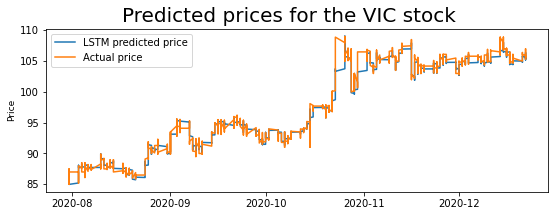

In [12]:
#Line Plot
ncols, nrows = factor_int(len(results))
fig, axes = plt.subplots(nrows, ncols, squeeze=False, figsize=(9*ncols, 3*nrows), sharex=True, sharey=True)

#Get actual prices
real_df = dataset_to_df(X_test, y_test, lag=lag)
if stock_name != None:
  real_df = real_df[real_df["Name"] == stock_name]

for (name, res), ax in zip(results.items(), axes.flatten()):
  #Plot predictions
  pred_df = results[name]['pred']
  ax.plot(pred_df['Date'], pred_df['Close'], label=f"{name} predicted price")
  #Plot actual prices
  ax.plot(real_df['Date'], real_df['Close'], label="Actual price")
  #Plot formatting
  ax.legend()
  ax.set_ylabel('Price', fontsize = 9)

#Figure Formatting
fig.suptitle(f'Predicted prices for the {stock_name} stock', fontsize = 20, fontdict=dict(weight='bold'))
fig.show()

In [13]:
mse_scores = []
mape_scores = []

mse_scores.append(results[name]['mse'])
mape_scores.append(results[name]['mape'])

In [14]:
#Mean Square Error
mse_scores

[<tf.Tensor: shape=(), dtype=float32, numpy=3.2211017e-05>]

In [15]:
#Mean Absolute Percentage Error
mape_scores

[<tf.Tensor: shape=(), dtype=float32, numpy=0.787835>]